<a href="https://colab.research.google.com/github/Manasi1/cmpe256/blob/main/AmazonModelTrainingEvaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Evaluation Metric for Training model for Amazon Reviews Data**

### **Importing Surprise library for Collabertive filtering algorithms, Pandas**
### **for loading dataset, and matplotlib library for visualizations**. 

In [36]:
# Credits-Prof Eirinaki, Rashmi Sharma and Aditya Patel
# conda install -c conda-forge scikit-surprise
!pip install scikit-surprise
from surprise import BaselineOnly
from surprise import Dataset
from surprise import Reader
from surprise.model_selection.split import train_test_split
from surprise.model_selection import cross_validate, GridSearchCV
import pandas as pd
import numpy as np
import os, io
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore, SlopeOne, NMF, CoClustering, NormalPredictor, KNNBaseline, BaselineOnly
from surprise import SVDpp
from surprise import SVD
from surprise import accuracy

from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# mount to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Get the dataframe from CSV named goodread_reviews_1.csv in Google Drive

# Go to folder containing CSV
%cd "/content/drive/My Drive/data/ce256/project"
# load first 4 million reviews
amazon_df = pd.read_csv("amazon_reviews_1")

# Check the CSV in Google Drive has the correct data
amazon_df.head()

/content/drive/.shortcut-targets-by-id/1HAaJ2jKojgPKa8wfJoWiFU_cYq8hnytg/project


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5.0,False,"03 30, 2005",A1REUF3A1YCPHM,0001713353,{'Format:': ' Hardcover'},TW Ervin II,"The King, the Mice and the Cheese by Nancy Gur...",A story children will love and learn from,1112140800,NaN,NaN
1,5.0,True,"06 20, 2016",AVP0HXC9FG790,0001713353,NaN,Amazon Customer,The kids loved it!,Five Stars,1466380800,NaN,NaN
2,5.0,True,"01 24, 2016",A324TTUBKTN73A,0001713353,{'Format:': ' Paperback'},Tekla Borner,My students (3 & 4 year olds) loved this book!...,Five Stars,1453593600,NaN,NaN
3,5.0,False,"07 9, 2015",A2RE7WG349NV5D,0001713353,{'Format:': ' Paperback'},Deborah K Woroniecki,LOVE IT,Five Stars,1436400000,NaN,NaN
4,5.0,True,"01 18, 2015",A32B7QIUDQCD0E,0001713353,NaN,E,Great!,Five Stars,1421539200,NaN,NaN


## Understanding the Metadata of the dataset

In [5]:
amazon_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000000 entries, 0 to 3999999
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   overall         float64
 1   verified        bool   
 2   reviewTime      object 
 3   reviewerID      object 
 4   asin            object 
 5   style           object 
 6   reviewerName    object 
 7   reviewText      object 
 8   summary         object 
 9   unixReviewTime  int64  
 10  vote            object 
 11  image           object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 339.5+ MB


In [7]:
amazon_df.describe()

,overall,unixReviewTime
count,4.000000e+06,4.000000e+06
mean,4.301729e+00,1.372402e+09
std,1.053463e+00,1.178078e+08
min,1.000000e+00,8.325504e+08
25%,4.000000e+00,1.348445e+09
50%,5.000000e+00,1.404691e+09
75%,5.000000e+00,1.446682e+09
max,5.000000e+00,1.525306e+09


## Calculate total count of each rating

In [10]:
total_count_rating = amazon_df.groupby('overall')['overall'].agg(['count'])
total_count_rating

,count
overall,
1.0,143760
2.0,179573
3.0,396912
4.0,885500
5.0,2394255


## Calculate Unique book ids, user ids and total rating count

In [12]:
book_count = amazon_df["asin"].nunique()
user_count = amazon_df['reviewerID'].nunique()
rating_count = amazon_df["overall"].count()

print('Unique Book Ids : ',book_count)
print('Unique User Ids : ',user_count)
print('Total rating count : ',user_count)

Unique Book Ids :  62209
Unique User Ids :  1208867
Total rating count :  1208867


# **Visualize the rating count**

In [14]:
rts_gp = amazon_df.groupby(by=['overall']).agg({'reviewerID': 'count'}).reset_index()
rts_gp.columns = ['Rating', 'Count']

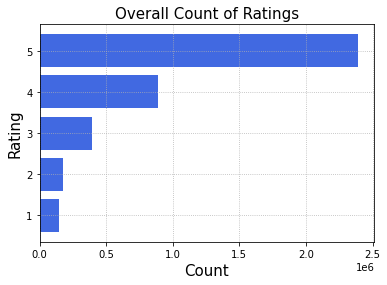

In [15]:
plt.barh(rts_gp.Rating, rts_gp.Count, color='royalblue')
plt.title('Overall Count of Ratings', fontsize=15)
plt.xlabel('Count', fontsize=15)
plt.ylabel('Rating', fontsize=15)
plt.grid(ls='dotted')
plt.show()

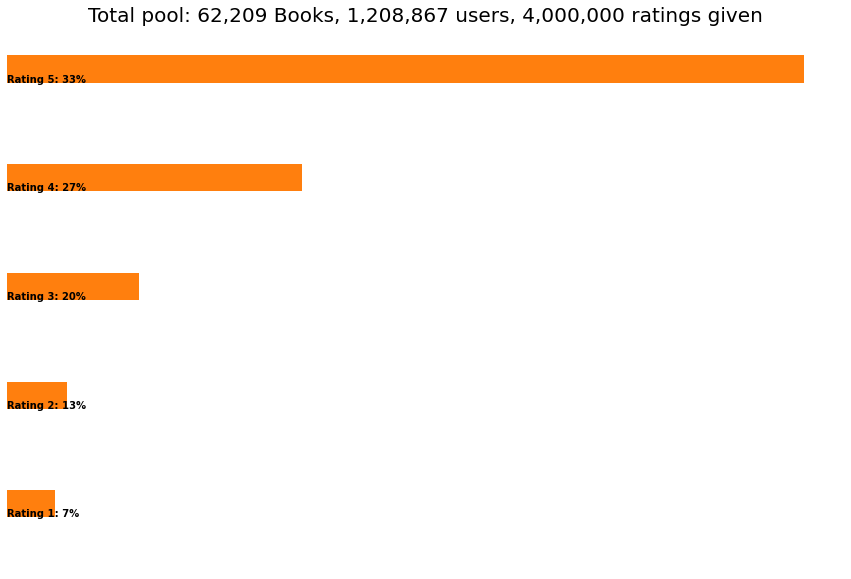

In [19]:
ax = rts_gp.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Books, {:,} users, {:,} ratings given'.format(book_count, user_count, rating_count), fontsize=20)
plt.axis('off')
          
for i in range(1,6):
    ax.text(rts_gp.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, rts_gp.iloc[i-1][0]*100 / rts_gp.sum()[0]), color = 'black', weight = 'bold')

# **Check for Null values in User id, Book Id, and Review Id**
As we will be using overall,reviewerId and asin for our model training. We are checking 

In [20]:
amazon_df.isnull().sum()

overall                 0
verified                0
reviewTime              0
reviewerID              0
asin                    0
style               57757
reviewerName          285
reviewText            495
summary               439
unixReviewTime          0
vote              3109783
image             3994761
dtype: int64

# **Data Slicing**

To deal with huge dataset we need to trim the dataset for training the model. This will also improve the quality of our dataset.
Delete rows that contains books with less reviews.
Delete rows that contains users who give too reviews

In [7]:
f = ['count','mean']

df_book_summary = amazon_df.groupby('asin')['overall'].agg(f)
book_benchmark = round(df_book_summary['count'].quantile(0.8),0)
drop_book_list = df_book_summary[df_book_summary['count'] < book_benchmark].index

print('Book minimum times of review: {}'.format(book_benchmark))

df_user_summary = amazon_df.groupby('reviewerID')['overall'].agg(f)
user_benchmark = round(df_user_summary['count'].quantile(0.8),0)
drop_user_list = df_user_summary[df_user_summary['count'] < user_benchmark].index

print('User minimum times of review: {}'.format(user_benchmark))

Book minimum times of review: 58.0
User minimum times of review: 4.0


# **Trim Data**

In [8]:
print('Original Shape: {}'.format(amazon_df.shape))
amazon_df = amazon_df[~amazon_df['asin'].isin(drop_book_list)]
amazon_df = amazon_df[~amazon_df['reviewerID'].isin(drop_user_list)]
print('After Trim Shape: {}'.format(amazon_df.shape))
print('-Data Examples-')
print(amazon_df.iloc[::20000, :])

Original Shape: (4000000, 12)
After Trim Shape: (1977131, 12)
-Data Examples-
         overall  verified   reviewTime  ... unixReviewTime vote image
79           3.0      True  05 12, 2003  ...     1052697600    6   NaN
33850        3.0      True  07 18, 2017  ...     1500336000  NaN   NaN
70892        5.0     False  08 24, 2014  ...     1408838400  NaN   NaN
116939       2.0      True   08 6, 2013  ...     1375747200    3   NaN
152643       3.0     False  01 10, 2005  ...     1105315200    2   NaN
...          ...       ...          ...  ...            ...  ...   ...
3796800      4.0      True   05 3, 2013  ...     1367539200  NaN   NaN
3841780      5.0      True  06 12, 2015  ...     1434067200    4   NaN
3883869      5.0     False   11 9, 2011  ...     1320796800  NaN   NaN
3924443      5.0     False  09 30, 2010  ...     1285804800  NaN   NaN
3964615      4.0     False  01 30, 2015  ...     1422576000  NaN   NaN

[99 rows x 12 columns]


# **Taking initial 25% of total books for Model training**
Using Full dataset   gives memory issue as it requires more than 30 GB ram for model training

In [9]:
amazon_df=amazon_df[:220000]

In [10]:
reader = Reader(rating_scale=(1,5))

data = Dataset.load_from_df(amazon_df[['reviewerID', 'asin', 'overall']], reader)


# **Splitting dataset in the ratio of 8:2**

In [12]:
#create training set
trainingSet, testSet = train_test_split(data, test_size=0.2, train_size=None, random_state=None, shuffle=True)

# **Defined Parameters for KNN**
For KNN we are using Cosine and Pearson similarity measure

In [10]:
#lets configure some parameters for Collaborative Filtering Algorithm
sim_cosine = {
    'name': 'cosine', #similarity measure default is MSD
    'user_based': False #user-based CF
}

In [11]:
sim_pearson = {
    'name': 'pearson', #similarity measure default is MSD
    'user_based': False #user-based CF
}

# **Defined Parameters for SVD**

In [12]:
#SVD
svd = SVD(n_factors=5, reg_all=0.1, n_epochs=1, biased = True, init_mean= 0, init_std_dev=0.1, lr_all=0.001)

In [13]:
svd.fit(trainingSet) #fit model to the training set
predictions_svd = svd.test(testSet) #predict for test set values

# **Cross Validation perfomed on SVD on 10k fold**

In [14]:
svd_cv = cross_validate(svd, data, cv=10, verbose=True) ##rerun the training part with different parameters

Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    1.0122  1.0209  1.0205  1.0130  1.0131  1.0269  1.0024  1.0142  1.0232  1.0140  1.0160  0.0066  
MAE (testset)     0.7969  0.8036  0.8030  0.7949  0.7960  0.8047  0.7904  0.7929  0.8034  0.7977  0.7984  0.0048  
Fit time          0.30    0.41    0.41    0.40    0.41    0.42    0.42    0.42    0.41    0.42    0.40    0.03    
Test time         0.15    0.15    0.35    0.15    0.15    0.16    0.18    0.35    0.15    0.15    0.20    0.08    


# **Cross Validation perfomed on NMF with 5k fold validation**

In [15]:
nmf_cv = cross_validate(NMF(), data, cv=5, n_jobs=5, verbose=False)

# **Cross Validation perfomed on SVDpp with 5k fold validation**

In [16]:
svdpp_cv = cross_validate(SVDpp(), data, cv=5, n_jobs=5, verbose=False)

# **Training Model using KNNBasic**

In [17]:
#KNN
knn = KNNBasic(sim_options=sim_cosine,k=3,min_k=1) #neighbours=3, other parameters set as above
knn.fit(trainingSet) #fit model to the training set
predictions_knn = knn.test(testSet) #predict for test set values

Computing the cosine similarity matrix...
Done computing similarity matrix.


# **Defining Parameters for KNNWithMeans**

In [24]:
knn_means = KNNWithMeans(sim_options=sim_cosine,k=3,min_k=1) #neighbours=3, other parameters set as above

# **Defining Parameters for KNNWithZScore**

In [26]:
knn_zero = KNNWithZScore(sim_options=sim_cosine,k=3,min_k=1) #neighbours=3, other parameters set as above

# **Cross validation performed on k-NN Based Algorithms**

In [18]:
knnbasic_cv = cross_validate(knn, data, cv=5, n_jobs=5, verbose=False)

In [25]:
knnmeans_cv = cross_validate(knn_means, data, cv=5, n_jobs=5, verbose=False)

In [27]:
knnz_cv = cross_validate(knn_zero, data, cv=5, n_jobs=5, verbose=False)

# **Cross validation performed using Co-Clustering and SlopeOne Algorithm using with 5k fold validation**

In [21]:
coclus_cv = cross_validate(CoClustering(), data, cv=5, n_jobs=5, verbose=False)

In [22]:
slope_cv = cross_validate(SlopeOne(), data, cv=5, n_jobs=5, verbose=False)

# **Comparison of all algorithms on RMSE and MAE**

In [28]:
print('Algorithm\t RMSE\t\t MAE')
print()
print('KNN Basic', '\t', round(knnbasic_cv['test_rmse'].mean(), 4), '\t', round(knnbasic_cv['test_mae'].mean(), 4))
print('KNN Means', '\t', round(knnmeans_cv['test_rmse'].mean(), 4), '\t', round(knnmeans_cv['test_mae'].mean(), 4))
print('KNN ZScore', '\t', round(knnz_cv['test_rmse'].mean(), 4), '\t', round(knnz_cv['test_mae'].mean(), 4))
print()
print('SVD', '\t\t', round(svd_cv['test_rmse'].mean(), 4), '\t', round(svd_cv['test_mae'].mean(), 4))
print('SVDpp', '\t\t', round(svdpp_cv['test_rmse'].mean(), 4), '\t', round(svdpp_cv['test_mae'].mean(), 4))
print('NMF', '\t\t', round(nmf_cv['test_rmse'].mean(), 4), '\t', round(nmf_cv['test_mae'].mean(), 4))
print()
print('SlopeOne', '\t', round(slope_cv['test_rmse'].mean(), 4), '\t', round(slope_cv['test_mae'].mean(), 4))
print('CoClustering', '\t', round(coclus_cv['test_rmse'].mean(), 4), '\t', round(coclus_cv['test_mae'].mean(), 4))
print()

Algorithm	 RMSE		 MAE

KNN Basic 	 1.0619 	 0.7236
KNN Means 	 1.0232 	 0.7192
KNN ZScore 	 1.0257 	 0.716

SVD 		 1.016 	 0.7984
SVDpp 		 0.958 	 0.7147
NMF 		 1.1148 	 0.8561

SlopeOne 	 1.0563 	 0.7338
CoClustering 	 1.0474 	 0.7268



# **Visualization of Evaluation Metric**

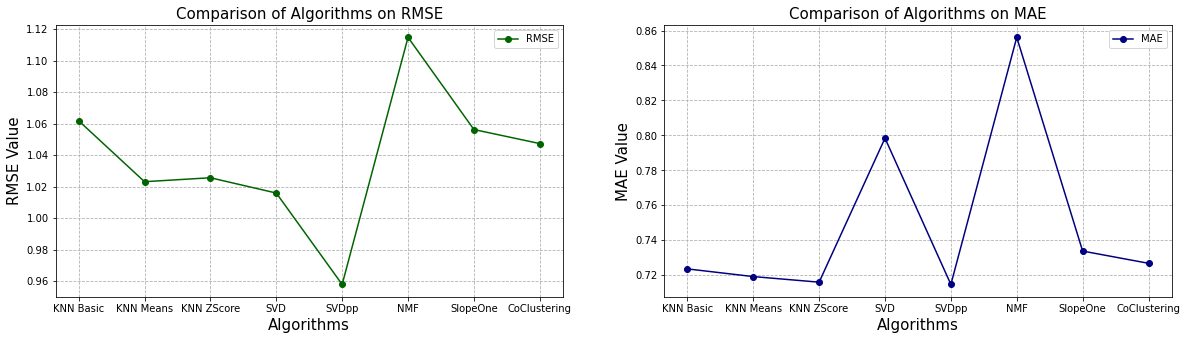

In [29]:
x_algo = ['KNN Basic', 'KNN Means', 'KNN ZScore', 'SVD', 'SVDpp', 'NMF', 'SlopeOne', 'CoClustering']
all_algos_cv = [knnbasic_cv, knnmeans_cv, knnz_cv, svd_cv, svdpp_cv, nmf_cv, slope_cv, coclus_cv]

rmse_cv = [round(res['test_rmse'].mean(), 4) for res in all_algos_cv]
mae_cv = [round(res['test_mae'].mean(), 4) for res in all_algos_cv]

plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
plt.title('Comparison of Algorithms on RMSE', loc='center', fontsize=15)
plt.plot(x_algo, rmse_cv, label='RMSE', color='darkgreen', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.subplot(1, 2, 2)
plt.title('Comparison of Algorithms on MAE', loc='center', fontsize=15)
plt.plot(x_algo, mae_cv, label='MAE', color='navy', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('MAE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.show()


# **Perform GridSearch CV on top two algorithms - SVDpp, SVD**

In [19]:
# Parameter space
svd_param_grid = {'n_epochs': [10, 20], 
                  'lr_all': [0.007, 0.009, 0.01, 0.001],
                  'reg_all': [0.4, 0.6, 0.2]}


svd_gs = GridSearchCV(SVD, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
svd_gs.fit(data)


# **Best parameters for SVD**

In [20]:
print('RMSE =', svd_gs.best_params['rmse'])
print('MAE =', svd_gs.best_params['mae'])

RMSE = {'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}
MAE = {'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}


# **Best RMSE and MAE Score using SVD**

In [21]:
print('SVD   - RMSE:', round(svd_gs.best_score['rmse'], 4), '; MAE:', round(svd_gs.best_score['mae'], 4))

SVD   - RMSE: 0.9533 ; MAE: 0.7301


In [22]:
svdpp_gs = GridSearchCV(SVDpp, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
svdpp_gs.fit(data)


# **Best parameters for SVDpp**

In [23]:
print('RMSE =', svdpp_gs.best_params['rmse'])
print('MAE =', svdpp_gs.best_params['mae'])

RMSE = {'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}
MAE = {'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}


# **Best RMSE and MAE Score using SVDpp**

In [24]:
print('SVDpp   - RMSE:', round(svdpp_gs.best_score['rmse'], 4), '; MAE:', round(svdpp_gs.best_score['mae'], 4))

SVDpp   - RMSE: 0.9542 ; MAE: 0.7303
